In [82]:
import pandas as pd
import random
import json
import os
import shutil
import numpy as np
import seaborn as sns
import matplotlib.pylab as plt
from scipy import stats

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import Pipeline

from sklearn import preprocessing
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline


In [83]:
df = pd.read_csv('db/comments_for_Arco.csv')

In [84]:
df.sectorName = df['sectorName'].str.lower()
df.cragName = df['cragName'].str.lower()
df.areaName = df['areaName'].str.lower()
df.zlaggableName = df['zlaggableName'].str.lower()

In [85]:
df = df[~df.cragName.isin(['valgua', 'corte'])]

In [86]:
df = df.drop_duplicates(subset=['userSlug', 'date', 'cragName', 'sectorName', 'zlaggableName', 'comment'], keep='last')
len(df)

53763

In [87]:
df = df.dropna(subset=['userSlug'])
len(df)

46506

In [88]:
dic_crags = {}
for crag in df.cragName.unique():
    dic_crags[crag] = crag

In [89]:
dic_crags['corno di bò'] = 'corno di bo'
dic_crags['al prà'] = 'al pra'
dic_crags['maso limarò'] = 'maso limaro'

In [90]:
df = df.replace({"cragName": dic_crags})

In [91]:
df = df.drop_duplicates(subset=['userSlug', 'date', 'cragName'], keep='last')

In [92]:
list_crags_include = df1.cragName.unique()
df = df[df.cragName.isin(list_crags_include)]

In [93]:
df['date'] = pd.to_datetime(df['date'], format="%Y-%m-%d")

In [94]:
df = df[df['date'].dt.date > pd.Timestamp(2008,1,1)]
df = df.sort_values(by="date")

In [95]:
df1 = df[df['date'].dt.date >= pd.Timestamp(2020,1,1)]
df2 = df[(df['date'].dt.date < pd.Timestamp(2020,1,1))]

In [96]:
dic_users_visits = {}
dic_users_crags = {}
for each_line in df1.index:
    user_slug = df1.loc[each_line, 'userSlug']
    cragName = df1.loc[each_line, 'cragName']
    if user_slug in dic_users_visits.keys():
        if cragName not in dic_users_crags[user_slug]:
            dic_users_visits[user_slug] += 1
            dic_users_crags[user_slug].append(cragName)
    else:
        dic_users_visits[user_slug] = 1
        dic_users_crags[user_slug] = [cragName]
            
users_with_more_than_five_crags = []
users_with_more_than_three_crags = []
users_with_more_than_ten_crags = []
users_with_more_than_twenty_crags = []
for user_slug in df1.userSlug.unique():
    if dic_users_visits[user_slug] >= 3:
        users_with_more_than_three_crags.append(user_slug)
    if dic_users_visits[user_slug] >= 5:
        users_with_more_than_five_crags.append(user_slug)
    if dic_users_visits[user_slug] >= 10:
        users_with_more_than_ten_crags.append(user_slug)
    if dic_users_visits[user_slug] >= 20:
        users_with_more_than_twenty_crags.append(user_slug)

In [97]:
print('three:', len(users_with_more_than_three_crags))
print('five:', len(users_with_more_than_five_crags))
print('ten:', len(users_with_more_than_ten_crags))
print('twenty:', len(users_with_more_than_twenty_crags))
print('unique users:', len(df1.userSlug.unique()))

three: 391
five: 165
ten: 27
twenty: 1
unique users: 902


In [21]:
df2 = df2[df2.userSlug.isin(users_with_more_than_three_crags)]
len(df2.userSlug.unique())

215

In [22]:
df1 = df1[df1.userSlug.isin(users_with_more_than_three_crags)]
df1 = df1[df1.userSlug.isin(df2.userSlug.unique())]
len(df1.userSlug.unique())

215

In [23]:
print(len(df2))
print(len(df1))

4034
1858


In [24]:
len(df2.cragName.unique())

88

In [25]:
len(df1.cragName.unique())

89

In [26]:
list_crags_include = list(df2.cragName.unique())
for crag in df1.cragName.unique():
    if crag not in list_crags_include:
        list_crags_include.append(crag)

In [27]:
dic_crags_id = {}
dic_crags_id_reverse = {}
i = 0
for cragName in sorted(list_crags_include):
    dic_crags_id[cragName] = i
    dic_crags_id_reverse[i] = cragName
    i += 1

In [81]:
len(list_crags_include)

98

In [28]:
dic_users = {}
dic_users_reverse = {}
i = 0
for userSlug in sorted(df1.userSlug.unique()):
    dic_users[userSlug] = i
    dic_users_reverse[i] = userSlug
    i += 1

In [29]:
users_num = len(df1.userSlug.unique())
crags_num = len(list_crags_include)

In [30]:
crag_visits_train = np.zeros((users_num, crags_num))
crag_visits_test = np.zeros((users_num, crags_num))

In [31]:
for each_line in df2.index:
    userSlug = df2.loc[each_line, 'userSlug']
    cragName = df2.loc[each_line, 'cragName']
    crag_id = dic_crags_id[cragName]
    user_id = dic_users[userSlug]
    crag_visits_train[user_id, crag_id] += 1

for each_line in df1.index:
    userSlug = df1.loc[each_line, 'userSlug']
    cragName = df1.loc[each_line, 'cragName']
    crag_id = dic_crags_id[cragName]
    user_id = dic_users[userSlug]
    crag_visits_test[user_id, crag_id] += 1

In [32]:
for userSlug in df1.userSlug.unique():
    user_id = dic_users[userSlug]
    for cragName in df1.cragName.unique():
        crag_id = dic_crags_id[cragName]
        if crag_visits_train[user_id, crag_id] > 5:
            crag_visits_train[user_id, crag_id] = 5
        if crag_visits_test[user_id, crag_id] > 5:
            crag_visits_test[user_id, crag_id] = 5

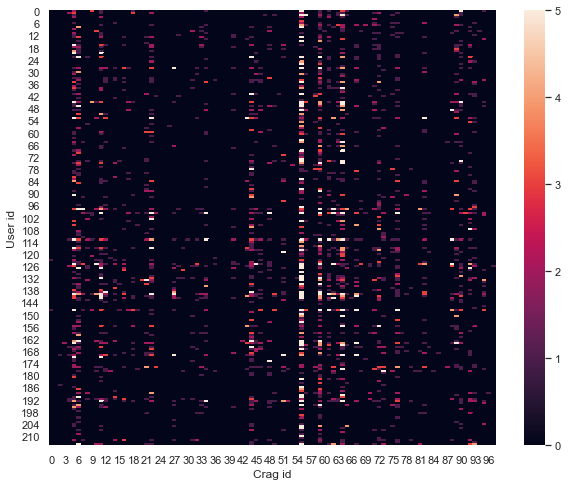

In [33]:
sns.set(rc={'figure.figsize':(10,8)})

ax = sns.heatmap(crag_visits_train)
ax.set(xlabel='Crag id', ylabel='User id')
plt.show()
plt.show()

# Crags content

In [98]:
crags_content = pd.read_csv('db/crags_features.csv', header=0, delimiter=';')
crags_content = crags_content.fillna(0)
crags_content['id'] = crags_content['Name crag']

In [99]:
crags_content['routes amount'] = crags_content['sum']
crags_content.head()

Name crag  #Routes   sum  approach, min    N    E    S    W   Ja   Fe  \
0       acheni      7.0   7.0              5  1.0  0.0  0.0  0.0  0.0  0.0   
1       al pra     54.0  54.0             15  0.0  1.0  0.0  1.0  0.0  0.0   
2  arcadioland     19.0  19.0             15  0.0  1.0  1.0  0.0  0.0  0.0   
3        athos     14.0  14.0             20  0.0  1.0  1.0  0.0  0.0  0.0   
4    babilonia     18.0  18.0             15  0.0  1.0  1.0  0.0  0.0  0.0   

   ...  porphyr  limestone  family-friendly  safety  height min  height max  \
0  ...      0.0        1.0              0.0       2          15          32   
1  ...      1.0        0.0              1.0       3           4          34   
2  ...      0.0        1.0              0.0       3           8          30   
3  ...      0.0        1.0              0.0       3          12          33   
4  ...      0.0        1.0              0.0       3          15          32   

   rain safe  rating           id  routes amount  
0        0.0       4       acheni            7.0  
1        0.0       3       al pra           54.0  
2        0.0       3  arcadioland           19.0  
3        0.0       4        athos           14.0  
4        0.0       4    babilonia           18.0  

[5 rows x 49 columns]

In [100]:
crags_content = crags_content.replace({"id": dic_crags_id})
crags_content.head()

Name crag  #Routes   sum  approach, min    N    E    S    W   Ja   Fe  \
0       acheni      7.0   7.0              5  1.0  0.0  0.0  0.0  0.0  0.0   
1       al pra     54.0  54.0             15  0.0  1.0  0.0  1.0  0.0  0.0   
2  arcadioland     19.0  19.0             15  0.0  1.0  1.0  0.0  0.0  0.0   
3        athos     14.0  14.0             20  0.0  1.0  1.0  0.0  0.0  0.0   
4    babilonia     18.0  18.0             15  0.0  1.0  1.0  0.0  0.0  0.0   

   ...  porphyr  limestone  family-friendly  safety  height min  height max  \
0  ...      0.0        1.0              0.0       2          15          32   
1  ...      1.0        0.0              1.0       3           4          34   
2  ...      0.0        1.0              0.0       3           8          30   
3  ...      0.0        1.0              0.0       3          12          33   
4  ...      0.0        1.0              0.0       3          15          32   

   rain safe  rating  id  routes amount  
0        0.0       4   0            7.0  
1        0.0       3   1           54.0  
2        0.0       3   2           19.0  
3        0.0       4   3           14.0  
4        0.0       4   4           18.0  

[5 rows x 49 columns]

In [101]:
X_df = crags_content[crags_content['Name crag'].isin(dic_crags_id.keys())].copy()
X_df = X_df.sort_values(by=['id'])
X_df.head()

Name crag  #Routes   sum  approach, min    N    E    S    W   Ja   Fe  \
0       acheni      7.0   7.0              5  1.0  0.0  0.0  0.0  0.0  0.0   
1       al pra     54.0  54.0             15  0.0  1.0  0.0  1.0  0.0  0.0   
2  arcadioland     19.0  19.0             15  0.0  1.0  1.0  0.0  0.0  0.0   
3        athos     14.0  14.0             20  0.0  1.0  1.0  0.0  0.0  0.0   
4    babilonia     18.0  18.0             15  0.0  1.0  1.0  0.0  0.0  0.0   

   ...  porphyr  limestone  family-friendly  safety  height min  height max  \
0  ...      0.0        1.0              0.0       2          15          32   
1  ...      1.0        0.0              1.0       3           4          34   
2  ...      0.0        1.0              0.0       3           8          30   
3  ...      0.0        1.0              0.0       3          12          33   
4  ...      0.0        1.0              0.0       3          15          32   

   rain safe  rating  id  routes amount  
0        0.0       4   0            7.0  
1        0.0       3   1           54.0  
2        0.0       3   2           19.0  
3        0.0       4   3           14.0  
4        0.0       4   4           18.0  

[5 rows x 49 columns]

In [46]:
X = np.array(X_df[['routes amount', 'approach, min', 'N', 'E', 'S', 'W',
       '<5a', '5a', '5b', '5c', '6a', '6b', '6c', '7a', '7b',
       '7c', '8a', '8b', '8c', '>8c', 'parking', 'overhang', 'roof',
       'vertical', 'slab', 'porphyr', 'limestone', 'family-friendly', 'safety',
       'height min', 'height max', 'rain safe', 'rating']])

len(X)

98

# Wonderful time-split

In [39]:
rmse = 0
mae = 0

rmse_average = 0
mae_average = 0

rmse_user = {}
mae_user = {}

rmse_average_user = {}
mae_average_user = {}

len_test = 0
for user_id in dic_users_reverse.keys():
    y_train = np.array(crag_visits_train[user_id])
    y_test = np.array(crag_visits_test[user_id])
    rmse_user[user_id] = 0
    mae_user[user_id] = 0
    
    rmse_average_user[user_id] = 0
    mae_average_user[user_id] = 0
    len_test = 0

    
    model = make_pipeline(
        preprocessing.MinMaxScaler(feature_range=(0,1)),   # scale each feature to 0-1
        PolynomialFeatures(degree=1, include_bias=False),
        LinearRegression()
    )

    # fit the pipeline
    model.fit(X, y_train)

    y_pred = model.predict(X)

    # end
    y_average_pred = np.full(y_test.shape, np.average(y_train))

    len_test += len(y_test)
    rmse_user[user_id] += mean_squared_error(y_test, y_pred, squared=False)
    rmse_average_user[user_id] += mean_squared_error(y_test, y_average_pred, squared=False)

    mae_user[user_id] += mean_absolute_error(y_test, y_pred)
    mae_average_user[user_id] += mean_absolute_error(y_test, y_average_pred)
    
    rmse_user[user_id] /= len_test
    rmse += rmse_user[user_id]
    
    rmse_average_user[user_id] /= len_test
    rmse_average += rmse_average_user[user_id]
    
    mae_user[user_id] /= len_test
    mae += mae_user[user_id]
    
    mae_average_user[user_id] /= len_test
    mae_average += mae_average_user[user_id]

print('RMSE:', np.round(rmse/len(dic_users_reverse.keys()), 5))
print('MAE:', np.round(mae/len( dic_users_reverse.keys()), 5))

print('RMSE average:', rmse_average/len(dic_users_reverse.keys()))
print('MAE average:', mae_average/len(dic_users_reverse.keys()))

RMSE: 0.00515
MAE: 0.00281
RMSE average: 0.004181762925843824
MAE average: 0.002286244835099757


In [77]:
map_user_average = {}
map_user = {}
recall_user = {}
recall_user_average = {}

len_test = 0
count_three_users = 0
n = 3
for user_id in dic_users_reverse.keys():
    y_train = np.array(crag_visits_train[user_id])
    y_test = np.array(crag_visits_test[user_id])

    map_user[user_id] = 0
    map_user_average[user_id] = 0
    recall_user[user_id] = 0
    recall_user_average[user_id] = 0

    model = make_pipeline(
        preprocessing.MinMaxScaler(feature_range=(0,1)),   # scale each feature to 0-1
        PolynomialFeatures(degree=4, include_bias=False),
        LinearRegression()
    )

    model.fit(X, y_train)
    
    y_pred = model.predict(X)
    y_pred_arr_sort = np.argsort(y_pred)[::-1][:n]
    y_pred_sort = np.round(y_pred[y_pred_arr_sort])
    num = 0
    for ar, el in zip(y_pred_arr_sort, y_pred_sort):
        num += 1
        if (el>0) and (y_test[ar]>0):
            map_user[user_id] += 1/num
            recall_user[user_id] += 1
    
    recall_user[user_id] /= len(y_test[np.nonzero(y_test)])
    y_test_sort = y_test[np.argsort(y_test)[::-1]][:n]

    relevant = n
    #if len(y_test_sort[np.nonzero(y_test_sort)])<n:
    #    relevant=len(y_test_sort[np.nonzero(y_test_sort)])

    map_user[user_id] /= relevant

    if np.round(np.average(y_train))>0:
        y_pred_average = random.choices([i for i in range(len(y_test))], k=n)
        
        num = 0
        for ar, el in zip(y_pred_average, np.full(y_test[:n].shape, np.average(y_train))):
            num += 1
            if (np.round(el)>0) and (y_test[ar]>0):
                map_user_average[user_id] += 1/num
                recall_user_average[user_id] += 1

        map_user_average[user_id] /= relevant
        recall_user_average[user_id] /= len(y_test[np.nonzero(y_test)])
    else:
        map_user_average[user_id] = 0

In [78]:
list_map5 = []
for k in map_user.keys():
    list_map5.append(map_user[k])
print(np.average(list_map5))

0.2170542635658915


In [79]:
list_recall = []
for k in recall_user.keys():
    list_recall.append(recall_user[k])
print(np.average(list_recall))

0.18772217370712582


In [69]:
list_map5_average = []
for k in map_user_average.keys():
    list_map5_average.append(map_user_average[k])
print(np.average(list_map5_average))

0.004134366925064599


In [70]:
list_recall_average = []
for k in recall_user_average.keys():
    list_recall_average.append(recall_user_average[k])
print(np.average(list_recall_average))

0.00427876576987384


In [221]:
mean_rmse = rmse/len(dic_users_reverse.keys())
squared_result = 0
for user_id in dic_users_reverse.keys():
    squared_result += (rmse_user[user_id] - mean_rmse)**2
    
print('Standard deviation rmse', (squared_result/len(dic_users_reverse.keys()))**0.5)

mean_mae = mae/len(dic_users_reverse.keys())
squared_result = 0
for user_id in dic_users_reverse.keys():
    squared_result += (mae_user[user_id] - mean_mae)**2
    
print('Standard deviation mae', (squared_result/len(dic_users_reverse.keys()))**0.5)

KeyError: 0

In [49]:
mean_rmse = rmse_average/len(dic_users_reverse.keys())
squared_result = 0
for user_id in dic_users_reverse.keys():
    squared_result += (rmse_average_user[user_id] - mean_rmse)**2
    
print('Standard deviation rmse average', (squared_result/len(dic_users_reverse.keys()))**0.5)

mean_mae = mae_average/len(dic_users_reverse.keys())
squared_result = 0
for user_id in dic_users_reverse.keys():
    squared_result += (mae_average_user[user_id] - mean_mae)**2
    
print('Standard deviation mae average:', (squared_result/len(dic_users_reverse.keys()))**0.5)

Standard deviation rmse average 0.002042700525614598
Standard deviation mae average: 0.0017868069787579388


In [38]:
list1 = []
list2 = []
for user_id in dic_users_reverse.keys():
    list1.append(rmse_user[user_id])
    list2.append(rmse_average_user[user_id])

In [39]:
stats.ttest_ind(list1, list2)

Ttest_indResult(statistic=4.373355194187763, pvalue=1.5383230173035425e-05)

# End of time split

In [ ]:
for each_ind in crags_content.index:
    name = crags_content.loc[each_ind, 'Name crag']
    if name in dic_crags_id.keys():
        crag_id = dic_crags_id[name]
        crags_content.loc[each_ind, 'visits'] = crag_visits[crag_id]
        crags_content.loc[each_ind, 'unique_visits'] = unique_crag_visits[crag_id]

In [ ]:
crags_content['all users'] = crags_content['visits']

In [50]:
crags_content = crags_content[crags_content.visits>3]

In [51]:
list_crags_include = crags_content['Name crag'].unique()

In [38]:
for user_Slug in dic_users.keys():
    current_user = dic_users[user_Slug]
    crags_content[str(current_user) + 'visits'] = 0

In [39]:
for each_ind in crags_content.index:
    name = crags_content.loc[each_ind, 'Name crag']
    if name in dic_crags_id.keys():
        crag_id = dic_crags_id[name]
        crags_content.loc[each_ind, 'visits'] = crag_visits[crag_id]
        for current_user in dic_users_reverse.keys():
            crags_content.loc[each_ind, str(current_user) + 'visits'] += crag_visits_per_user[current_user, crag_id]

crags_content.head()

NameError: name 'crag_visits' is not defined

In [77]:
user1, user2, user3 = ['150visits', '181visits', '202visits']# 1136 1131'1151visits','1153visits']'1117visits'
#crags_content = crags_content.rename(columns={user1: "user 1", user2: "user 2", user3: "user 3"})
#user1, user2, user3 = ["user 1", "user 2", "user 3"]

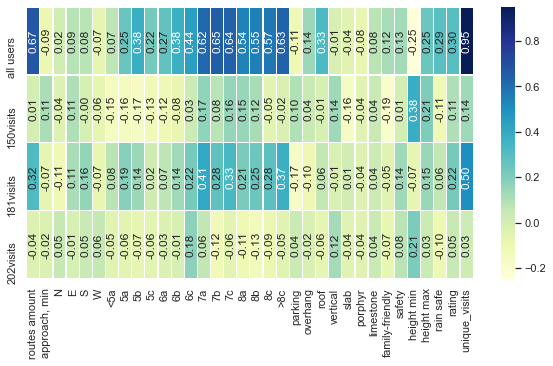

In [78]:
corr = crags_content[['routes amount', 'approach, min', 'N', 'E', 'S', 'W',
                          '<5a', '5a', '5b', '5c', '6a', '6b', '6c', '7a', '7b',
       '7c', '8a', '8b', '8c', '>8c', 'parking', 'overhang', 'roof',
       'vertical', 'slab', 'porphyr', 'limestone', 'family-friendly', 'safety',
       'height min', 'height max', 'rain safe', 'rating', 'unique_visits', user1, user2, user3, 'all users']].corr()
corr = corr.loc[['all users', user1, user2, user3], ['routes amount', 'approach, min', 'N', 'E', 'S', 'W',
                          '<5a', '5a', '5b', '5c', '6a', '6b', '6c', '7a', '7b',
       '7c', '8a', '8b', '8c', '>8c', 'parking', 'overhang', 'roof',
       'vertical', 'slab', 'porphyr', 'limestone', 'family-friendly', 'safety',
       'height min', 'height max', 'rain safe', 'rating', 'unique_visits']]
sns.heatmap(corr,annot=True, fmt='.2f', annot_kws={'rotation': 90}, cmap="YlGnBu",linewidths=0.2) #data.corr()-->матрица корреляций
# gcf() - получение текущей фигуры
fig=plt.gcf()
# set_size_inches() - установить размер фигуры
fig.set_size_inches(10,5)

# save the figure
#plt.savefig('visits_correlation1.png', dpi=300, bbox_inches='tight')
plt.show()

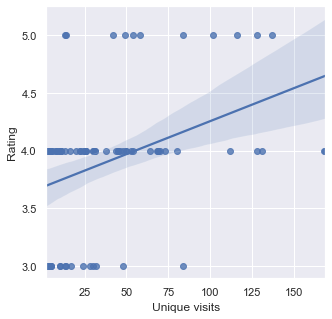

In [86]:
sns.regplot(x="unique_visits", y="rating", data=crags_content)
# gcf() - получение текущей фигуры
fig=plt.gcf()
# set_size_inches() - установить размер фигуры
fig.set_size_inches(5,5)

# save the figure
plt.xlabel('Unique visits')
plt.ylabel('Rating')
plt.savefig('rating_visits_cor.png', dpi=300, bbox_inches='tight')
plt.show()

In [87]:
degree_n=2

rmse = 0
mae = 0

rmse_user = {}
mae_user = {}

len_test = 0
for user_id in dic_users_reverse.keys():

    y = np.array(crag_visits_per_user[user_id])
    rmse_user[user_id] = 0
    mae_user[user_id] = 0
    len_test = 0
    for i in range(3):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

        # define the pipeline
        pipe = Pipeline(steps=[
            ('scaler', StandardScaler()),
            ('preprocessor', PolynomialFeatures(degree=degree_n, include_bias=False)),
            ('estimator', Ridge(alpha=1))
        ])

        # fit the pipeline
        pipe.fit(X_train, y_train)

        range_sort = np.argsort(y_test)[::-1]
        
        X_test_sort = X_test[range_sort]
        y_test_sort = y_test[range_sort]

        y_pred_sort = pipe.predict(X_test_sort)
        y_pred = y_pred_sort[:10]
        
        y_test = y_test_sort[:10]
        
        len_test += len(y_pred)
        rmse_user[user_id] += mean_squared_error(y_test, y_pred, squared=False)
        mae_user[user_id] += mean_absolute_error(y_test, y_pred)
    rmse_user[user_id] /= len_test
    rmse += rmse_user[user_id]
    mae_user[user_id] /= len_test
    mae += mae_user[user_id]
    
print('RMSE:', rmse/len( dic_users_reverse.keys()))
print('MAE:', mae/len( dic_users_reverse.keys()))

RMSE: 0.36312493158157744
MAE: 0.17519653574243188


In [62]:
mean_rmse = rmse/len(dic_users_reverse.keys())
squared_result = 0
for user_id in dic_users_reverse.keys():
    squared_result += (rmse_user[user_id] - mean_rmse)**2
    
print('Variance rmse:', squared_result/len(crag_visits_per_user))
print('Standard deviation rmse', (squared_result/len(crag_visits_per_user))**0.5)

mean_mae = mae/len(dic_users_reverse.keys())
squared_result = 0
for user_id in dic_users_reverse.keys():
    squared_result += (mae_user[user_id] - mean_mae)**2
    
print('Variance mae:', squared_result/len(crag_visits_per_user))
print('Standard deviation mae', (squared_result/len(crag_visits_per_user))**0.5)

Variance rmse: 0.00026080331616774817
Standard deviation rmse 0.016149406062383475
Variance mae: 0.0001573928396730918
Standard deviation mae 0.012545630301945446


In [438]:
sectors = pd.read_csv('sectors.csv', header=0, delimiter=';')
sectors = sectors.fillna(0)

In [439]:
sectors = sectors[sectors['Name crag']=='massone']

In [440]:
for each in ['<5a', '5a',
       '5b', '5c', '6a', '6b', '6c', '7a', '7b', '7c', '8a', '8b', '8c', '>8c', 'multipitch']:
    sectors[each] = sectors[each].astype('int')
for each in ['Lower', 'Intermediate', 'Advanced', 'Elite',
       'Higher Elite', 'Lower1', 'Intermediate1', 'Advanced1', 'Elite1',
       'Higher Elite1', 'Lower2', 'Intermediate2', 'Advanced2', 'Elite2',
       'Higher Elite2']:
    
    sectors[each] = sectors[each].astype(str).str.replace(',','.')
    sectors[each] = sectors[each].astype('float')

In [441]:
sectors[['Lower', 'Intermediate', 'Advanced', 'Elite',
       'Higher Elite']].head()

Lower  Intermediate  Advanced  Elite  Higher Elite
144   12.0          10.0       1.0    0.0           0.0
145    0.0           9.0      15.0    4.0           0.0
146    0.0           1.0      15.0    6.0           1.0
147    3.0          10.0       6.0    2.0           0.0
148    0.0           3.0       7.0    0.0           0.0

In [442]:
df2 = sectors[sectors['Name sector'].isin(['B 1','B 2'])].sum(axis=0, numeric_only=True)
df2['Name sector'] = 'B'
df2['Name crag'] = 'massone'
sectors = sectors.append(df2, ignore_index = True)


In [443]:
df2 = sectors[sectors['Name sector'].isin(['E - Abissi 1', 'E - Abissi 2'])].sum(axis=0, numeric_only=True)
df2['Name sector'] = 'E'
df2['Name crag'] = 'massone'
sectors = sectors.append(df2, ignore_index = True)


In [444]:
df2 = sectors[sectors['Name sector'].isin(['F - Pueblo 1', 'F - Pueblo 2', 'F - Pueblo 3'])].sum(axis=0, numeric_only=True)
df2['Name sector'] = 'F'
df2['Name crag'] = 'massone'
sectors = sectors.append(df2, ignore_index = True)


In [445]:
sectors = sectors[sectors['Name sector'].isin(['A', 'B', 'C', 'D', 'E','F'])]

In [446]:
for each in ['Lower', 'Intermediate', 'Advanced', 'Elite',
       'Higher Elite']:
    sectors[each] = sectors[each].astype('int')

In [448]:
#axis=0, numeric_only=True
sectors['Lower1'] = sectors['Lower']/sectors[['<5a', '5a',
       '5b', '5c', '6a', '6b', '6c', '7a', '7b', '7c', '8a', '8b', '8c', '>8c']].sum(axis=1, numeric_only=True)
sectors['Intermediate1'] = sectors['Intermediate']/sectors[['<5a', '5a',
       '5b', '5c', '6a', '6b', '6c', '7a', '7b', '7c', '8a', '8b', '8c', '>8c']].sum(axis=1, numeric_only=True)
sectors['Advanced1'] =sectors['Advanced']/sectors[['<5a', '5a',
       '5b', '5c', '6a', '6b', '6c', '7a', '7b', '7c', '8a', '8b', '8c', '>8c']].sum(axis=1, numeric_only=True)
sectors['Elite1'] = sectors['Elite']/sectors[['<5a', '5a',
       '5b', '5c', '6a', '6b', '6c', '7a', '7b', '7c', '8a', '8b', '8c', '>8c']].sum(axis=1, numeric_only=True)
sectors['Higher Elite1'] = sectors['Higher Elite']/sectors[['<5a', '5a',
       '5b', '5c', '6a', '6b', '6c', '7a', '7b', '7c', '8a', '8b', '8c', '>8c']].sum(axis=1, numeric_only=True)

In [449]:
#axis=0, numeric_only=True
sectors['Lower2'] = np.where(sectors['Lower1']>= 0.2, 1, 0)
sectors['Intermediate2'] =  np.where(sectors['Intermediate1']>= 0.2, 1, 0)
sectors['Advanced2'] = np.where(sectors['Advanced1']>= 0.2, 1, 0)
sectors['Elite2'] = np.where(sectors['Elite1']>= 0.2, 1, 0)
sectors['Higher Elite2'] = np.where(sectors['Higher Elite1']>= 0.2, 1, 0)

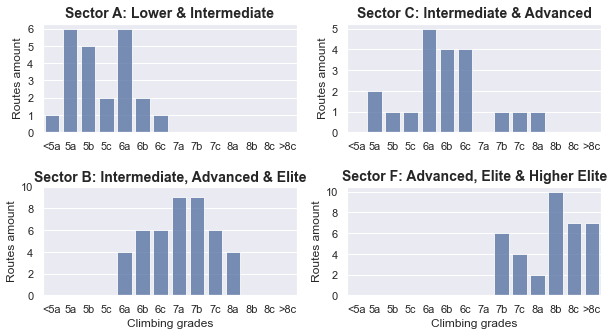

In [450]:
import warnings
warnings.filterwarnings('ignore')
x1 = ['<5a', '5a', '5b', '5c', '6a', '6b', '6c', '7a', '7b', '7c', '8a', '8b', '8c', '>8c']
len_x1 = len(['<5a', '5a', '5b', '5c', '6a', '6b', '6c', '7a', '7b', '7c', '8a', '8b', '8c', '>8c'])
figure, axes = plt.subplots(2, 2, sharex=False, figsize=(10,5))

axes[0,0].set_title('Sector A: Lower & Intermediate', weight='bold').set_fontsize('14')
axes[0,1].set_title('Sector C: Intermediate & Advanced', weight='bold').set_fontsize('14')
axes[1,0].set_title('Sector B: Intermediate, Advanced & Elite', weight='bold').set_fontsize('14')
axes[1,1].set_title('Sector F: Advanced, Elite & Higher Elite', weight='bold').set_fontsize('14')
plt.subplots_adjust(hspace = 0.5)

y1 = list(sectors[sectors['Name sector']=='A'][x1].values)[0]

#sns.lineplot(x=x1, y=[np.sum(y1)/5 for i in range(len_x1)], color='r', sort = False, ax=ax1)
g1 = sns.barplot(x1, y=y1, color='b', alpha  = 0.8, ax=axes[0,0])
g1.set_ylabel("Routes amount")#, fontsize = 20)
max_y = int(max(y1)+1)
g1.set_yticks(range(0, max_y, int(max_y/5)))
#g1.set_xlabel("Climbing grades")

y1 = list(sectors[sectors['Name sector']=='C'][x1].values)[0]

g2 = sns.barplot(x1, y=y1, color='b', alpha  = 0.8, ax=axes[0,1])
g2.set_ylabel("Routes amount")#, fontsize = 20)
max_y = int(max(y1)+1)
g2.set_yticks(range(0, max_y, int(max_y/5)))
#g2.set_xlabel("Climbing grades")

y1 = list(sectors[sectors['Name sector']=='B'][x1].values)[0]
g3 = sns.barplot(x1, y=y1, color='b', alpha  = 0.8, ax=axes[1,0])
g3.set_ylabel("Routes amount")#, fontsize = 20)
g3.set_xlabel("Climbing grades")#, fontsize = 20)
max_y = int(max(y1)+2)
g3.set_yticks(range(0, max_y, int(max_y/5)))

y1 = list(sectors[sectors['Name sector']=='F'][x1].values)[0]

g4 = sns.barplot(x1, y=y1, color='b', alpha  = 0.8, ax=axes[1,1])
g4.set_ylabel("Routes amount")#, fontsize = 20)
g4.set_xlabel("Climbing grades")#, fontsize = 20)
max_y = int(max(y1)+1)
g4.set_yticks(range(0, max_y, int(max_y/5)))
#g.set_xticklabels(['0','a','b','c','d','e'])
# save the figure
plt.savefig('histogram_sectors.png', dpi=300, bbox_inches='tight')
plt.show()

In [451]:
sectors[sectors['Name sector']=='A']

Name crag     id Name sector  Routes num   Sum  <5a   5a   5b   5c   6a  \
0   massone  145.0           A        23.0  23.0  1.0  6.0  5.0  2.0  6.0   

   ...    Lower1  Intermediate1  Advanced1  Elite1  Higher Elite1  Lower2  \
0  ...  0.521739       0.434783   0.043478     0.0            0.0       1   

   Intermediate2  Advanced2  Elite2  Higher Elite2  
0              1          0       0              0  

[1 rows x 36 columns]

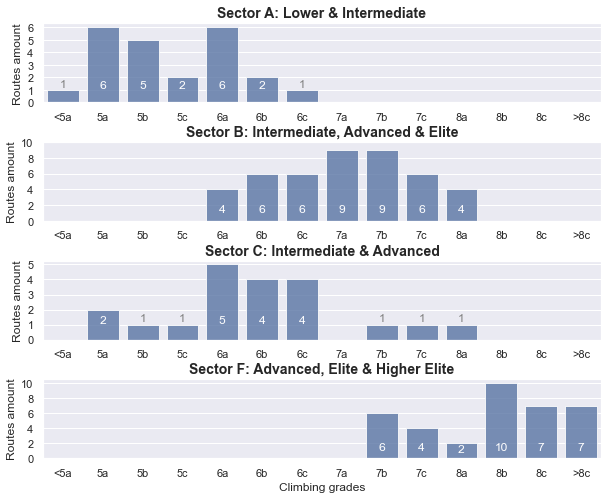

In [482]:
import warnings
warnings.filterwarnings('ignore')
x1 = ['<5a', '5a', '5b', '5c', '6a', '6b', '6c', '7a', '7b', '7c', '8a', '8b', '8c', '>8c']
len_x1 = len(['<5a', '5a', '5b', '5c', '6a', '6b', '6c', '7a', '7b', '7c', '8a', '8b', '8c', '>8c'])
figure, axes = plt.subplots(4, 1, sharex=False, figsize=(10,8))

axes[0].set_title('Sector A: Lower & Intermediate', weight='bold').set_fontsize('14')
axes[1].set_title('Sector B: Intermediate, Advanced & Elite', weight='bold').set_fontsize('14')
axes[2].set_title('Sector C: Intermediate & Advanced', weight='bold').set_fontsize('14')
axes[3].set_title('Sector F: Advanced, Elite & Higher Elite', weight='bold').set_fontsize('14')
plt.subplots_adjust(hspace = 0.5)

y1 = list(sectors[sectors['Name sector']=='A'][x1].values)[0]

#sns.lineplot(x=x1, y=[np.sum(y1)/5 for i in range(len_x1)], color='r', sort = False, ax=ax1)
g1 = sns.barplot(x1, y=y1, color='b', alpha  = 0.8, ax=axes[0])
g1.set_ylabel("Routes amount")#, fontsize = 20)
max_y = int(max(y1)+1)
g1.set_yticks(range(0, max_y, int(max_y/5)))

for each_x, each_y in zip([i for i in range(len(x1))], y1):
    if each_y>0:
        if each_y>1:
            g1.text(each_x, 1.1, round(each_y),
                        color='white', ha='center')
        else:
            g1.text(each_x, 1.2, round(each_y),
                        color='gray', ha='center')

y1 = list(sectors[sectors['Name sector']=='B'][x1].values)[0]
g3 = sns.barplot(x1, y=y1, color='b', alpha  = 0.8, ax=axes[1])
g3.set_ylabel("Routes amount")#, fontsize = 20)
#g3.set_xlabel("Climbing grades")#, fontsize = 20)
max_y = int(max(y1)+2)
g3.set_yticks(range(0, max_y, int(max_y/5)))

for each_x, each_y in zip([i for i in range(len(x1))], y1):
    if each_y>0:
        if each_y>1:
            g3.text(each_x, 1.1, round(each_y),
                        color='white', ha='center')
        else:
            g3.text(each_x, 1.2, round(each_y),
                        color='gray', ha='center')
            
y1 = list(sectors[sectors['Name sector']=='C'][x1].values)[0]

g2 = sns.barplot(x1, y=y1, color='b', alpha  = 0.8, ax=axes[2])
g2.set_ylabel("Routes amount")#, fontsize = 20)
max_y = int(max(y1)+1)
g2.set_yticks(range(0, max_y, int(max_y/5)))
for each_x, each_y in zip([i for i in range(len(x1))], y1):
    if each_y>0:
        if each_y>1:
            g2.text(each_x, 1.1, round(each_y),
                        color='white', ha='center')
        else:
            g2.text(each_x, 1.2, round(each_y),
                        color='gray', ha='center')
            
y1 = list(sectors[sectors['Name sector']=='F'][x1].values)[0]

g4 = sns.barplot(x1, y=y1, color='b', alpha  = 0.8, ax=axes[3])
g4.set_ylabel("Routes amount")#, fontsize = 20)
g4.set_xlabel("Climbing grades")#, fontsize = 20)
max_y = int(max(y1)+1)
g4.set_yticks(range(0, max_y, int(max_y/5)))
for each_x, each_y in zip([i for i in range(len(x1))], y1):
    if each_y>0:
        if each_y>2:
            g4.text(each_x, 1.1, round(each_y),
                        color='white', ha='center')
        else:
            g4.text(each_x, 0.8, round(each_y),
                        color='white', ha='center')
#g.set_xticklabels(['0','a','b','c','d','e'])
# save the figure
plt.savefig('histogram_sectors.png', dpi=300, bbox_inches='tight')
plt.show()

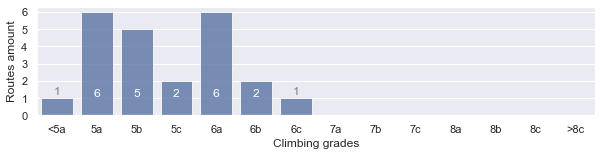

In [481]:
x1 = ['<5a', '5a', '5b', '5c', '6a', '6b', '6c', '7a', '7b', '7c', '8a', '8b', '8c', '>8c']
len_x1 = len(['<5a', '5a', '5b', '5c', '6a', '6b', '6c', '7a', '7b', '7c', '8a', '8b', '8c', '>8c'])
sns.set(rc={'figure.figsize':(10,2)})

axes.set_title('Sector A: Lower & Intermediate', weight='bold').set_fontsize('14')

plt.subplots_adjust(hspace = 0.5)

y1 = list(sectors[sectors['Name sector']=='A'][x1].values)[0]

#sns.lineplot(x=x1, y=[np.sum(y1)/5 for i in range(len_x1)], color='r', sort = False, ax=ax1)
g1 = sns.barplot(x1, y=y1, color='b', alpha  = 0.8)
g1.set_ylabel("Routes amount")#, fontsize = 20)
g1.set_xlabel("Climbing grades")#, fontsize = 20)
max_y = int(max(y1)+1)
g1.set_yticks(range(0, max_y, int(max_y/5)))

for each_x, each_y in zip([i for i in range(len(x1))], y1):
    if each_y>0:
        if each_y>1:
            g1.text(each_x, 1.1, round(each_y),
                        color='white', ha='center')
        else:
            g1.text(each_x, 1.2, round(each_y),
                        color='gray', ha='center')
plt.savefig('histogram_1.png', dpi=300, bbox_inches='tight')
plt.show()


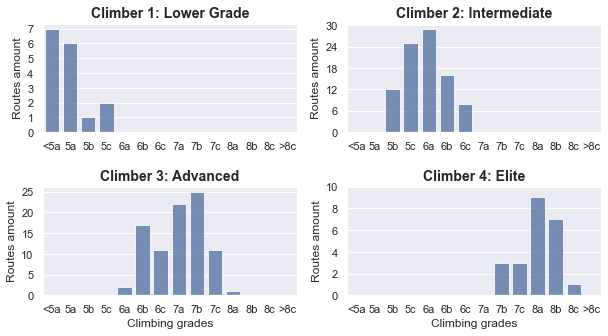

In [430]:
import warnings
warnings.filterwarnings('ignore')
x1 = ['<5a', '5a', '5b', '5c', '6a', '6b', '6c', '7a', '7b', '7c', '8a', '8b', '8c', '>8c']
len_x1 = len(['<5a', '5a', '5b', '5c', '6a', '6b', '6c', '7a', '7b', '7c', '8a', '8b', '8c', '>8c'])
figure, axes = plt.subplots(2, 2, sharex=False, figsize=(10,5))

axes[0,0].set_title('Climber 1: Lower Grade', weight='bold').set_fontsize('14')
axes[0,1].set_title('Climber 2: Intermediate', weight='bold').set_fontsize('14')
axes[1,0].set_title('Climber 3: Advanced', weight='bold').set_fontsize('14')
axes[1,1].set_title('Climber 4: Elite', weight='bold').set_fontsize('14')
plt.subplots_adjust(hspace = 0.5)

y1 = [7, 6, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

#sns.lineplot(x=x1, y=[np.sum(y1)/5 for i in range(len_x1)], color='r', sort = False, ax=ax1)
g1 = sns.barplot(x1, y=y1, color='b', alpha  = 0.8, ax=axes[0,0])
g1.set_ylabel("Routes amount")#, fontsize = 20)
max_y = int(max(y1)+1)
g1.set_yticks(range(0, max_y, int(max_y/5)))
#g1.set_xlabel("Climbing grades")

y1 = [0, 0, 12, 25, 29, 16, 8, 0, 0, 0, 0, 0, 0, 0]

g2 = sns.barplot(x1, y=y1, color='b', alpha  = 0.8, ax=axes[0,1])
g2.set_ylabel("Routes amount")#, fontsize = 20)
max_y = int(max(y1)+2)
g2.set_yticks(range(0, max_y, int(max_y/5)))
#g2.set_xlabel("Climbing grades")

y1 = [0, 0, 0, 0, 2, 17, 11, 22, 25, 11, 1, 0, 0, 0]
g3 = sns.barplot(x1, y=y1, color='b', alpha  = 0.8, ax=axes[1,0])
g3.set_ylabel("Routes amount")#, fontsize = 20)
g3.set_xlabel("Climbing grades")#, fontsize = 20)
max_y = int(max(y1)+2)
g3.set_yticks(range(0, max_y, int(max_y/5)))

y1 = [0, 0, 0, 0, 0, 0, 0, 0, 3, 3, 9, 7, 1, 0]

g4 = sns.barplot(x1, y=y1, color='b', alpha  = 0.8, ax=axes[1,1])
g4.set_ylabel("Routes amount")#, fontsize = 20)
g4.set_xlabel("Climbing grades")#, fontsize = 20)
max_y = int(max(y1)+2)
g4.set_yticks(range(0, max_y, int(max_y/5)))
#g.set_xticklabels(['0','a','b','c','d','e'])
# save the figure
plt.savefig('climbers_profiles.png', dpi=300, bbox_inches='tight')
plt.show()


In [410]:
np.random.random(len_x1)*100//10

array([1., 0., 4., 4., 8., 4., 9., 8., 5., 9., 4., 9., 8., 6.])